# House dataset

In this notebook, we follow Chapter 2 of the book "Hands-On Machine Learning with Scikit-Learn and PyTorch". We need to create a model to predict the median housing price based on a dataset.

In [1]:
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request
def load_housing_data():
 tarball_path = Path("datasets/housing.tgz")
 if not tarball_path.is_file():
    Path("datasets").mkdir(parents=True, exist_ok=True)
    url = "https://github.com/ageron/data/raw/main/housing.tgz"  #if not present download it 
    urllib.request.urlretrieve(url, tarball_path)
    with tarfile.open(tarball_path) as housing_tarball:
        housing_tarball.extractall(path="datasets")
 return pd.read_csv(Path("datasets/housing/housing.csv"))
housing_full = load_housing_data()

In [82]:
# Dataset info

#housing_full.info()
#housing_full["ocean_proximity"].value_counts()  #count values with a given attribute of the key ocean_proximity
housing_full.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


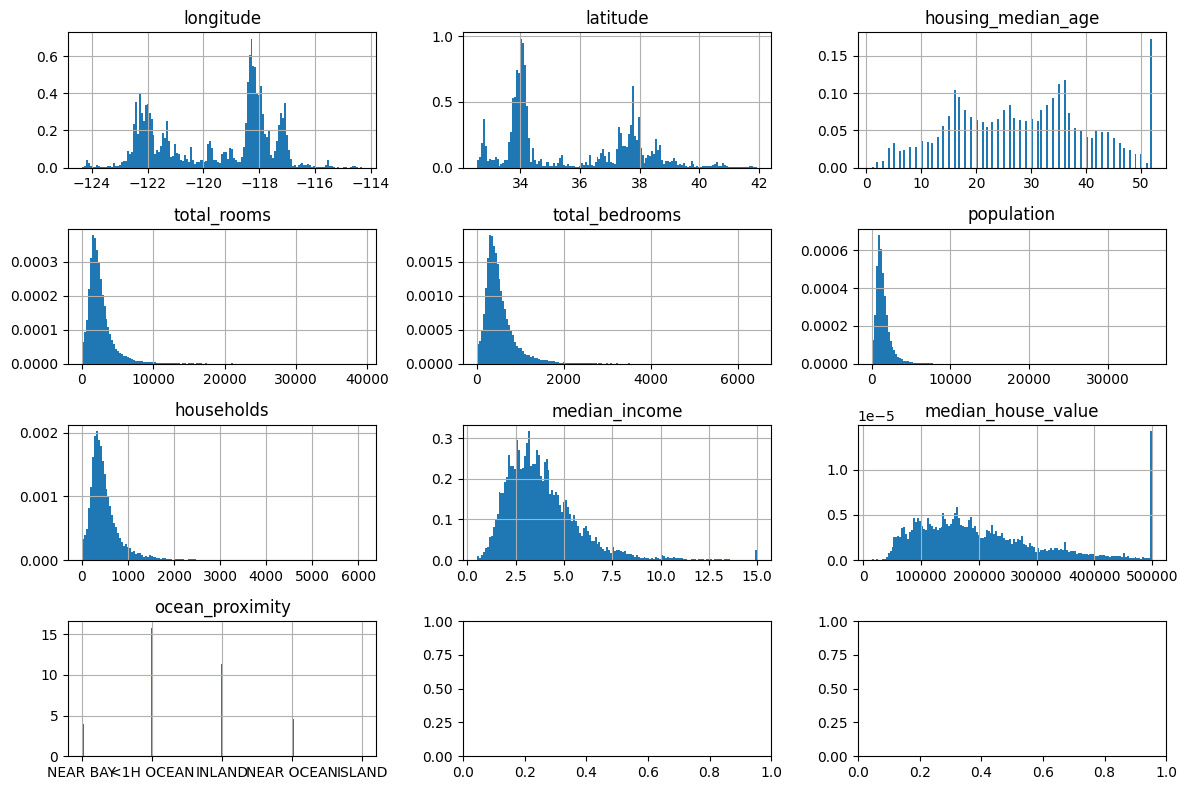

In [83]:
import matplotlib.pyplot as plt
import numpy as np


fig, axes = plt.subplots(nrows=int(np.ceil(len(housing_full.keys())/3)), ncols=3, figsize=(12,8))  # adjust rows/cols as needed
axes = axes.flatten()

for i, col in enumerate(housing_full):
    housing_full[col].hist(bins = int(np.sqrt(len(housing_full[col]))), figsize=(12,8), density = True, ax=axes[i])
    axes[i].set_title(col)
    
plt.tight_layout()
plt.show()

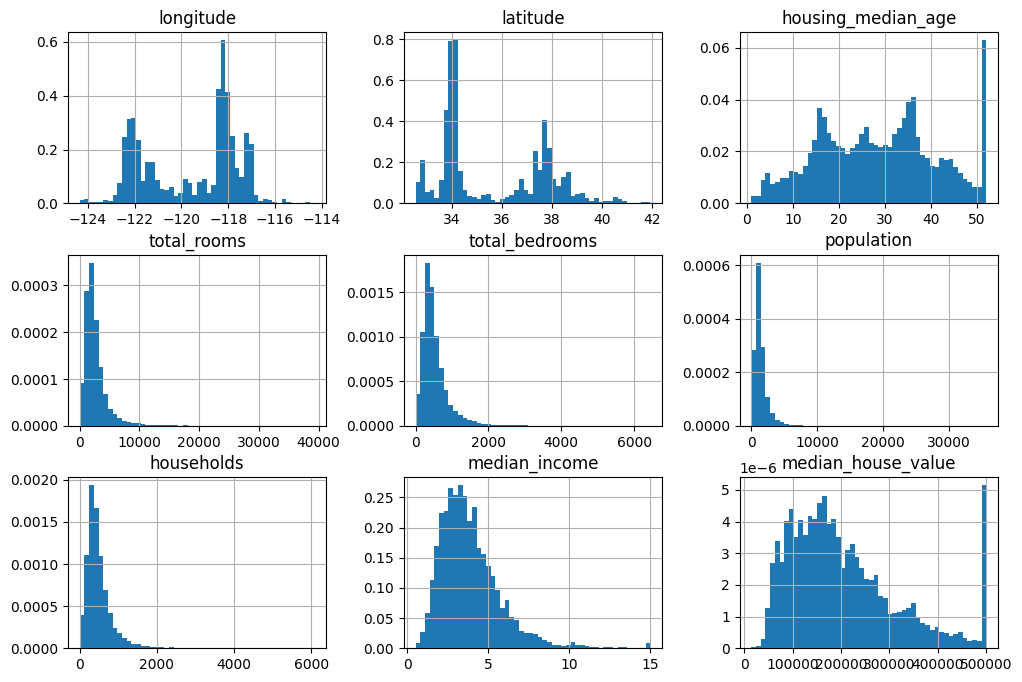

In [84]:
housing_full.hist(bins = 50, figsize=(12,8), density = True)

plt.show()

## Splitting the dataset

In [85]:
from zlib import crc32

def is_id_in_test(identifier, test_ratio):

    return crc32(np.int64(identifier)) < (2**32)*test_ratio


def split_data_with_id_hash(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(is_id_in_test, args = (test_ratio, ))
    return  data.loc[~in_test_set], data.loc[in_test_set]


housing_with_id = housing_full.reset_index() # adds an `index` column
train_set, test_set = split_data_with_id_hash(housing_with_id, 0.2,"index")

Assigning IDs based on row numbers is problematic. If the dataset changes (e.g., rows are removed or new rows are inserted at the beginning or end), some samples may shift from the training set to the test set, leading to data leakage. This should be avoided, as the test set must remain unseen during training.

In these cases, it is better to rely on a stable feature (i.e., a feature that is unlikely to change when the dataset is updated). For our dataset, the latitude and longitude of the house location serve as good stable features.

In [86]:
housing_with_id["id"] = (housing_full["longitude"] * 1000 + housing_full["latitude"])
train_set, test_set = split_data_with_id_hash(housing_with_id, 0.2, "id")

Experts have indicated that median income is an important factor for predicting housing prices. 
To ensure our training and test sets reflect this, we need both sets to contain the same 
proportion of houses across different income levels. Unequal proportions could lead to biased results.

To achieve this, we perform stratified sampling. We first divide median income into several 
categories based on chosen ranges, then assign each house to the appropriate category. 
This ensures that both the training and test sets maintain similar distributions of income levels, 
leading to a more reliable model evaluation.


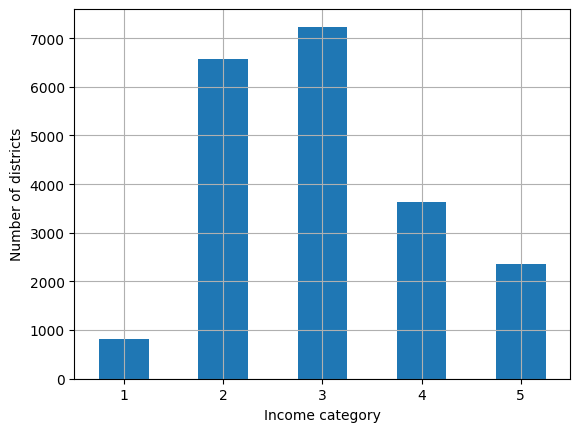

In [87]:
housing_full["income_cat"] = pd.cut(housing_full["median_income"], bins=[0., 1.5, 3.0, 4.5, 6.,np.inf], labels=[1, 2, 3, 4, 5]).astype(int)  #we use astype(int) so that the feature "income_cat" is numeric and not categorical

cat_counts = housing_full["income_cat"].value_counts().sort_index()
cat_counts.plot.bar(rot=0, grid=True)
plt.xlabel("Income category")
plt.ylabel("Number of districts")
plt.show()

In [88]:
from sklearn.model_selection import train_test_split

strat_train_set, strat_test_set = train_test_split(housing_full, test_size=0.2, stratify=housing_full["income_cat"], random_state=42)

print(strat_train_set["income_cat"].value_counts().sort_index()/len(strat_train_set["income_cat"]))

print(strat_test_set["income_cat"].value_counts().sort_index()/len(strat_test_set["income_cat"]))

print(housing_full["income_cat"].value_counts().sort_index()/len(housing_full["income_cat"]))


# We needed this income_cat just to stratified sample the train and test set. We can now delete it in place

for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)


income_cat
1    0.039789
2    0.318859
3    0.350594
4    0.176296
5    0.114462
Name: count, dtype: float64
income_cat
1    0.039971
2    0.318798
3    0.350533
4    0.176357
5    0.114341
Name: count, dtype: float64
income_cat
1    0.039826
2    0.318847
3    0.350581
4    0.176308
5    0.114438
Name: count, dtype: float64


We can see that the training set, the test set, and the full dataset all have approximately the same proportion of each income category.

# Data exploration

In this phase, we explore the data in the training set for example by producing some plots. It is a good idea to make a copy of the training set so that if we apply some transformations to it we do not lose the original.

<Axes: xlabel='longitude', ylabel='latitude'>

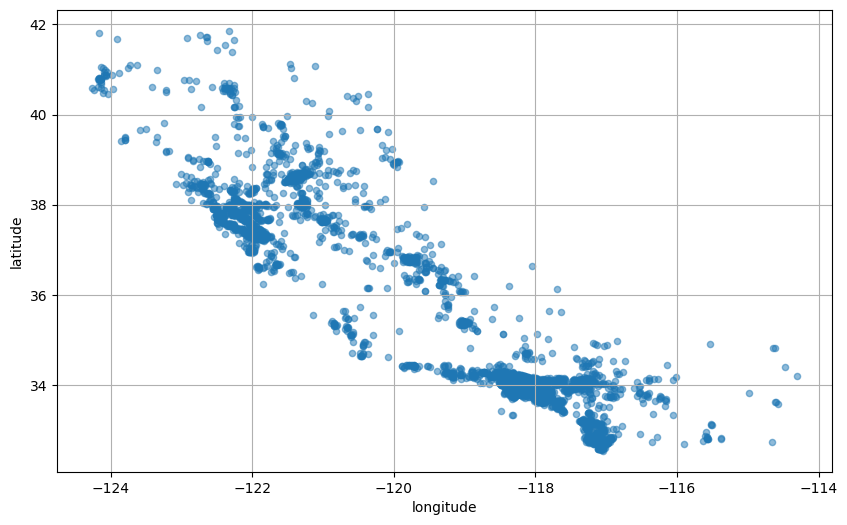

In [89]:
housing = strat_test_set.copy()

housing.plot(kind = "scatter", x = "longitude", y = "latitude", grid = True, alpha = 0.5, figsize = (10,6))

We can also make a more sophisticated plot. We colour the dots based on how expensive the area is and the radius of each dots scales proportionally to the population in that area. Note, when we use the colomap, it is important to choose one that is perceptually uniform, "jet" is usually bad, it is better to use "viridis".

<Axes: xlabel='longitude', ylabel='latitude'>

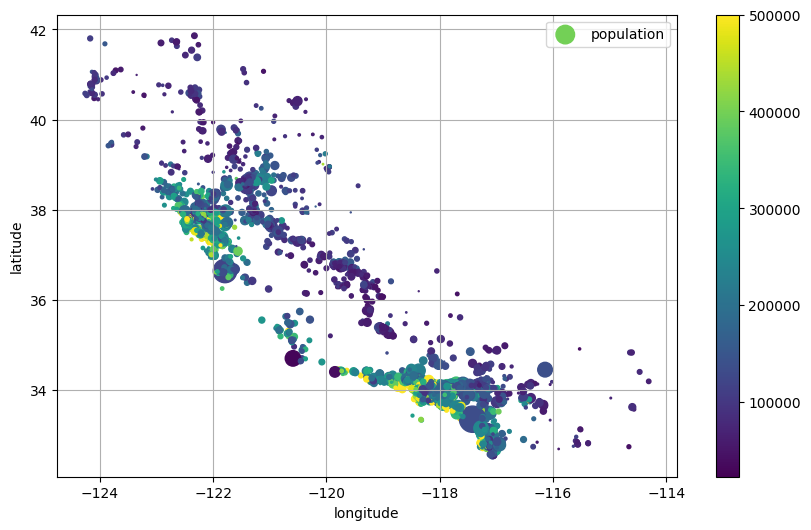

In [90]:
housing.plot(kind = "scatter", x = "longitude", y = "latitude",  s=housing["population"]/100, sharex = False, label = "population", c = housing["median_house_value"], cmap = "viridis", grid = True, figsize = (10,6))

## Correlation

Something else to check is the correlation.

In [91]:
corr_matrix = housing.corr(numeric_only=True)


corr_matrix["median_house_value"].sort_values(ascending = False)

median_house_value    1.000000
median_income         0.687091
total_rooms           0.121070
housing_median_age    0.118976
households            0.043549
total_bedrooms        0.029600
longitude            -0.026768
population           -0.040286
latitude             -0.162087
Name: median_house_value, dtype: float64

A good way to plot correlation is to use a scatter matrix, basically we plot each feature against each other.

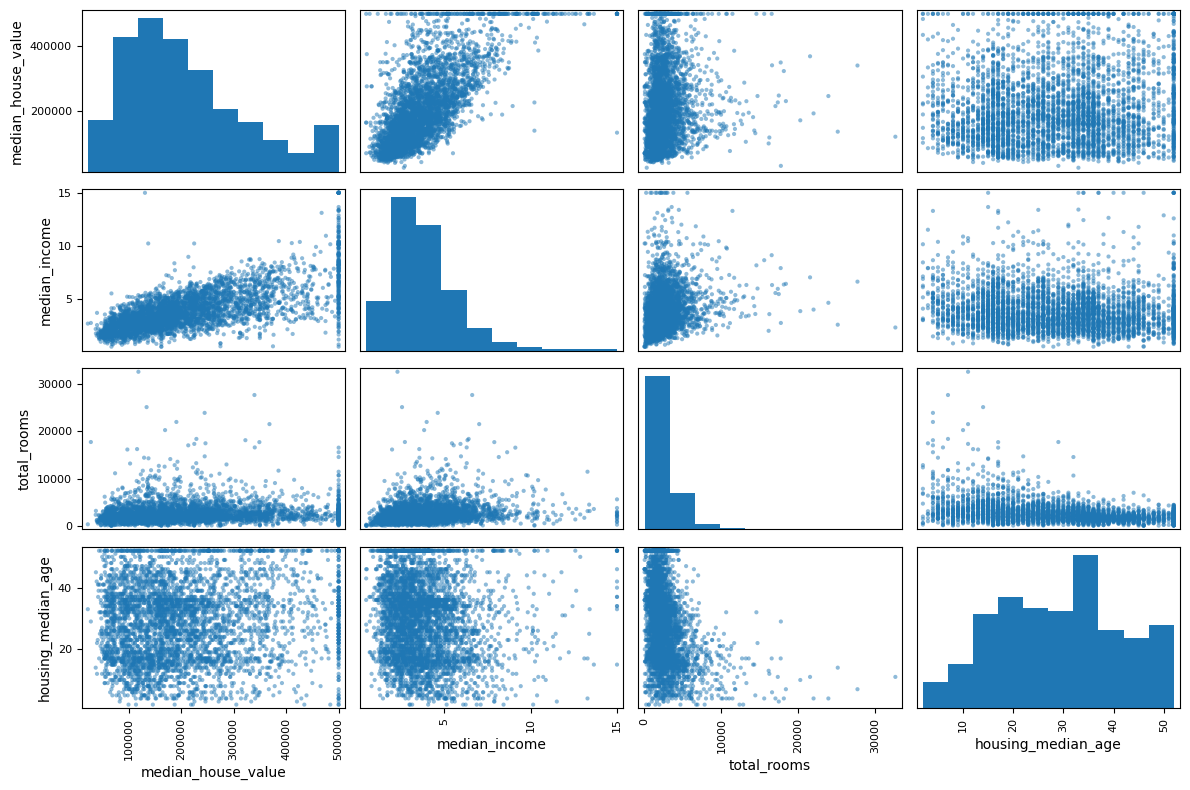

In [92]:
from pandas.plotting import scatter_matrix


#scatter_matrix(housing.select_dtypes(include = "number"), figsize = (12,8))  #this includes all numerical columns


attributes = ["median_house_value", "median_income", "total_rooms","housing_median_age"]

scatter_matrix(housing[attributes], figsize = (12,8))

plt.tight_layout()
plt.show()

## Interpreting a scatter matrix plot

Given some numerical features $X_1, \dots, X_n$, the scatter matrix is a panel plot of $X_i$ versus $X_j$ for all combinations. On the diagonal, we do not plot $X_i$ versus $X_i$ since this would trivially be a straight line; by default, pandas instead plots a histogram of the feature $X_i$.

A scatter matrix plot is mainly meant to highlight whether two variables have a linear relationship. Linear correlation does not capture nonlinear relationships.

This can be easily understood from the following example. Consider a random variable defined as $Y = \alpha X$. Then the correlation between $X$ and $Y$ is

$$
\mathrm{corr}(X,Y)
= \frac{\mathrm{cov}(X,Y)}{\sqrt{\mathrm{var}(X)\mathrm{var}(Y)}}
= \frac{\mathrm{cov}(X,\alpha X)}{\sqrt{\mathrm{var}(X)\mathrm{var}(\alpha X)}}
= \frac{\alpha\,\mathrm{var}(X)}{\sqrt{\alpha^2 \mathrm{var}(X)\mathrm{var}(X)}}
= \mathrm{sgn}(\alpha).
$$

We can see that the correlation extracts the sign of the coefficient in front of the linear term. However, it does not capture nonlinear relationships. We can have $\mathrm{corr}(X,Y)=0$ while the variables $X$ and $Y$ are still dependent.

For example, if $Y = X^2$ and the distribution of $X$ is symmetric around zero (so that $\mathbb{E}[X^{2n+1}] = 0$), then

$$
\mathrm{corr}(X,Y)
= \frac{\mathrm{cov}(X,X^2)}{\sqrt{\mathrm{var}(X)\mathrm{var}(X^2)}}
= \frac{\mathbb{E}[X^3]-\mathbb{E}[X]\mathbb{E}[X^2]}{\sqrt{\mathrm{var}(X)\mathrm{var}(X^2)}}
= 0.
$$

In a scatter matrix plot, if points follow a straight line, there will be a non-zero correlation. If the line has a positive slope, the correlation is positive; otherwise, it is negative.

The previous scatter matrix plot shows that median_income and median_house_value are the most correlated,  in fact the correlation is 0.687091, which is positive as it can be inferred from the plot since the data points alligns on a straight line with positive gradient.

In [93]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4128 entries, 3905 to 3455
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           4128 non-null   float64
 1   latitude            4128 non-null   float64
 2   housing_median_age  4128 non-null   float64
 3   total_rooms         4128 non-null   float64
 4   total_bedrooms      4089 non-null   float64
 5   population          4128 non-null   float64
 6   households          4128 non-null   float64
 7   median_income       4128 non-null   float64
 8   median_house_value  4128 non-null   float64
 9   ocean_proximity     4128 non-null   object 
dtypes: float64(9), object(1)
memory usage: 354.8+ KB


## Attribute combinations

When exploring the data, we can transform some of the features to generate new features that may be more informative. For example, the dataset includes features such as `total_bedrooms`, `total_rooms`, `population`, and `households`. It may be more informative to compute:

- bedrooms per room  
- rooms per household  
- population per household  

Note: Avoid trivial transformations that simply combine features linearly without adding new information.

In [94]:
housing["rooms_per_house"] = housing["total_rooms"]/housing["households"]
housing["bedrooms per room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["people_per_house"] = housing["population"]/housing["households"]

We can then recompute the correlation matrix and notice that the new features are much more correlated with median_house_value.

In [95]:
corr = housing.corr(numeric_only=True)["median_house_value"]

corr.loc[corr.abs().sort_values(ascending = False).index] #orderd in ascending order based on the absolute value.

median_house_value    1.000000
median_income         0.687091
bedrooms per room    -0.254506
rooms_per_house       0.198322
latitude             -0.162087
total_rooms           0.121070
housing_median_age    0.118976
households            0.043549
population           -0.040286
total_bedrooms        0.029600
longitude            -0.026768
people_per_house     -0.025974
Name: median_house_value, dtype: float64

## Data cleaning
After exploring the dataset, we now need to clean it to prepare it for feeding it into an ML algorithm. It is also good practice to separate the predictors from the labels.
Sometimes, some values might be missing. We should check whether some values are NaN and, if so, decide how to handle them. Some common strategies are:

1. Remove the entire feature that contains NaN values (drop the columns containing NaNs from the dataframe)
2. Remove the data points containing NaN values (drop the rows containing NaNs from the dataframe)
3. Replace the NaN values with a meaningful value (mean, median, or most frequent value). This is called imputation.


In [96]:
#Separate predictors and labels

housing = strat_train_set.drop("median_house_value", axis = 1)

housing_labels = strat_train_set["median_house_value"].copy()


housing_full[housing_full.isna().any(axis=1)] # this shows the rows that contains any columns with NaNs

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,income_cat
182,-118.27,34.04,13.0,1784.0,NaN,2158.0,682.0,1.7038,118100.0,<1H OCEAN,2
327,-117.65,34.04,15.0,3393.0,NaN,2039.0,611.0,3.9336,151000.0,INLAND,3
366,-122.50,37.75,44.0,1819.0,NaN,1137.0,354.0,3.4919,271800.0,NEAR OCEAN,3
477,-117.99,34.14,30.0,2346.0,NaN,1988.0,474.0,2.5625,153000.0,INLAND,2
495,-114.59,34.83,41.0,812.0,NaN,375.0,158.0,1.7083,48500.0,INLAND,2
...,...,...,...,...,...,...,...,...,...,...,...
19880,-118.23,33.94,36.0,1110.0,NaN,1417.0,302.0,2.3333,92100.0,<1H OCEAN,2
19952,-119.19,34.20,18.0,3620.0,NaN,3171.0,779.0,3.3409,220500.0,NEAR OCEAN,3
20088,-119.73,36.83,8.0,3602.0,NaN,1959.0,580.0,5.3478,138800.0,INLAND,4
20325,-118.88,34.17,15.0,4260.0,NaN,1701.0,669.0,5.1033,410700.0,<1H OCEAN,4


**Note:** In pandas, selecting a column like `strat_train_set["median_house_value"]` may return either a **view** or a **copy** of the data. 

- A **view** points to the original data in memory. Modifying it can **accidentally change the original DataFrame**, which can lead to subtle bugs.  
- A **copy** is a completely independent object. Changes to it **do not affect** the original DataFrame.

Therefore, it is safer to explicitly use `.copy()`:

```python
housing_labels = strat_train_set["median_house_value"].copy()

To highlight the subtlety, consider the example below

In [97]:
df_1 = pd.DataFrame({"A": [1,2,3], "B": [10,20,30]})

df_2 = pd.DataFrame({"A": [1,2,3], "B": [10,20,30]})

var_1 = df_1["A"]

var_2 = df_2["A"].copy()

print("Before", df_1)

var_1[0] = 4

print("After", df_1)

print("Before", df_2)

var_2[0] = 4

print("After", df_2) 

Before    A   B
0  1  10
1  2  20
2  3  30
After    A   B
0  4  10
1  2  20
2  3  30
Before    A   B
0  1  10
1  2  20
2  3  30
After    A   B
0  1  10
1  2  20
2  3  30


Notice how if we do not use .copy() the original DataFrame is changed. However, we need to be careful if the copied object contains mutable elements (for example lists) channging those in the copied version results in a change in the original dataframe. This is usually no desriable, to avoid this we can make a deepcopy instead of a shallow copy. Usually deepcopy() will copy recursively each nested object so that no nested object points to the original one. However, for some reaons this does not happen with Pandas dataframe. A workaround is to turn back the dataframe to a dictionary and then deepcopy the dictionary

In [98]:
import pandas as pd
from copy import deepcopy

print("=== Case 1: Shallow copy of a column ===")
df_1 = pd.DataFrame({"A": [1, 2, 3], "B": [[10], [20], [30]]})
shallow = df_1["B"].copy()  # shallow copy

print("Original nested object IDs:")
print("df_1['B'][0]:", id(df_1["B"][0]))
print("shallow[0]:", id(shallow[0]))
print("IDs are the same?", id(shallow[0]) == id(df_1["B"][0]))

# Modify the shallow copy
shallow[0].append(999)
print("\nAfter modifying shallow[0]:")
print("df_1['B'] =\n", df_1["B"])  # original is modified
print("shallow =", shallow)

print("\n=== Case 2: deepcopy of a column ===")
df_2 = pd.DataFrame({"A": [1, 2, 3], "B": [[10], [20], [30]]})
deep = deepcopy(df_2["B"])  # deep copy

print("Original nested object IDs:")
print("df_2['B'][0]:", id(df_2["B"][0]))
print("deep[0]:", id(deep[0]))
print("IDs are the same?", id(deep[0]) == id(df_2["B"][0]))

# Modify the deep copy
deep[0].append(999)
print("\nAfter modifying deep[0]:")
print("df_2['B'] = \n", df_2["B"])  # original is unchanged
print("deep =", deep)

print("\n=== Case 3: deepcopy of entire DataFrame via to_dict ===")
df_3 = pd.DataFrame({"A": [1, 2, 3], "B": [[10], [20], [30]]})
deep_2 = pd.DataFrame(deepcopy(df_3.to_dict(orient="list")))  # deep copy

print("Original nested object IDs:")
print("df_3['B'][0]:", id(df_3["B"][0]))
print("deep_2['B'][0]:", id(deep_2["B"][0]))
print("IDs are the same?", id(deep_2["B"][0]) == id(df_3["B"][0]))

# Modify deep copy
deep_2["B"][0].append(999)
print("\nAfter modifying deep_2['B'][0]:")
print("df_3['B'] =\n", df_3["B"])    # original is unchanged
print("deep_2 =", deep_2)




=== Case 1: Shallow copy of a column ===
Original nested object IDs:
df_1['B'][0]: 2438648430208
shallow[0]: 2438648430208
IDs are the same? True

After modifying shallow[0]:
df_1['B'] =
 0    [10, 999]
1         [20]
2         [30]
Name: B, dtype: object
shallow = 0    [10, 999]
1         [20]
2         [30]
Name: B, dtype: object

=== Case 2: deepcopy of a column ===
Original nested object IDs:
df_2['B'][0]: 2438664732480
deep[0]: 2438664732480
IDs are the same? True

After modifying deep[0]:
df_2['B'] = 
 0    [10, 999]
1         [20]
2         [30]
Name: B, dtype: object
deep = 0    [10, 999]
1         [20]
2         [30]
Name: B, dtype: object

=== Case 3: deepcopy of entire DataFrame via to_dict ===
Original nested object IDs:
df_3['B'][0]: 2438652038528
deep_2['B'][0]: 2438652048128
IDs are the same? False

After modifying deep_2['B'][0]:
df_3['B'] =
 0    [10]
1    [20]
2    [30]
Name: B, dtype: object
deep_2 =    A          B
0  1  [10, 999]
1  2       [20]
2  3       [30]


In [99]:
# Replacing missing data

# Option 1

housing.columns[housing.isna().any()]

# housing.drop('total_bedrooms', axis = 1, inplace=True) #Option 1

# housing.dropna(subset = ["total_bedrooms"], inplace = True) #Option2

# median = housing["total_bedrooms"].median()
# housing["total_bedrooms"] = housing["total_bedrooms"].fillna(median)


Index(['total_bedrooms'], dtype='object')

## Imputation with Scikit-Learn

Instead of using pandas to perform imputation, it is often better to use **scikit-learn**, especially when building machine learning pipelines.

The scikit-learn API is simple and consistent. Most objects fall into one (or more) of these categories:

* **Estimators**: learn parameters from a dataset  
* **Transformers**: transform a dataset using learned parameters  
* **Predictors**: make predictions on new data  

In our case, `SimpleImputer` is used to handle missing data. This class is both:

- An **estimator**, because it learns a parameter from the data (such as mean, median, or most frequent value) that will be used to replace missing values.  
- A **transformer**, because it applies this learned parameter to transform the dataset by filling in missing values.  

---

### General scikit-learn workflow

Depending on the object type, we typically use these methods:

* **Estimators** → `fit()`  
  - Learns parameters from the training data.  

* **Transformers** → `transform()`  
  - Applies the learned transformation to the data.  

* **Predictors** → `predict()`  
  - Generates predictions on new data.  

Often, we combine steps using `fit_transform()`, which fits the model and transforms the data in one step.

In [100]:
from sklearn.impute import SimpleImputer

inputer = SimpleImputer(strategy="median")

housing_num = housing.select_dtypes(include=[np.number])

inputer.fit(housing_num)

inputer.statistics_


X = inputer.transform(housing_num) #this is a numpy array

housing_tr = pd.DataFrame(X, columns=housing_num.columns, index=housing_num.index) # this is a dataframe

housing_tr.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16512 entries, 13096 to 19888
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           16512 non-null  float64
 1   latitude            16512 non-null  float64
 2   housing_median_age  16512 non-null  float64
 3   total_rooms         16512 non-null  float64
 4   total_bedrooms      16512 non-null  float64
 5   population          16512 non-null  float64
 6   households          16512 non-null  float64
 7   median_income       16512 non-null  float64
dtypes: float64(8)
memory usage: 1.1 MB


In [101]:
np.unique(housing[["ocean_proximity"]])

array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
      dtype=object)

## Transforming Categorical Features

In general, machine learning algorithms work best with numerical data.  
To convert non-numerical (categorical) data into numbers, we use **encoders**.

Two common encoding methods are:

- Ordinal Encoding  
- One-Hot Encoding  

---

### Ordinal Encoding

This is the simplest approach. It counts the number of unique categories and assigns an integer to each one, for example:

$$
\{0, 1, \dots, \text{number of categories} - 1\}
$$

Ordinal encoding is appropriate when categories have a **natural order**.  
For example:

$$
\{\text{bad}, \text{average}, \text{good}\} \rightarrow \{0, 1, 2\}
$$

This makes sense because *bad < average < good*.

---

### When Ordinal Encoding Is Not Appropriate

If categories do **not** have a natural order, ordinal encoding can introduce false relationships.  
For example:

$$
\{\text{Snake}, \text{Lion}, \text{Tiger}\}
$$

There is no meaningful ordering between these animals, so mapping them to:

$$
\{0, 1, 2\}
$$

would incorrectly suggest that one category is “larger” or “closer” than another.

---

### One-Hot Encoding

In these cases, it is better to use **one-hot encoding**.

Instead of one categorical feature, we create one binary feature per category.

For example, if a feature takes values in:

$$
\{\text{Snake}, \text{Lion}, \text{Tiger}\}
$$

we create **three new binary features**:

- Snake → $(1, 0, 0)$  
- Lion → $(0, 1, 0)$  
- Tiger → $(0, 0, 1)$  

Each observation gets:
- 1 for its category  
- 0 for all other categories  

This avoids introducing artificial ordering between categories.

In [102]:
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder


categorical_features = housing.select_dtypes(exclude = "number").columns

print(categorical_features)


ordinal_encoder = OrdinalEncoder()


housing_cat_ord = ordinal_encoder.fit_transform(housing[["ocean_proximity"]])

print(housing_cat_ord)

one_hot_encoder = OneHotEncoder(sparse_output=False)  #If we next turn it into a dataframe we do not need a sparse matrix but a np array

housing_cat_onehot = one_hot_encoder.fit_transform(housing[["ocean_proximity"]]) #sparse matrix representing the onehot encoder


print(housing_cat_onehot)


one_hot_encoder.categories_

Index(['ocean_proximity'], dtype='object')
[[3.]
 [0.]
 [1.]
 ...
 [4.]
 [0.]
 [4.]]
[[0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]]


[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

Even if after applying transform() to a dataframe, the result is a numpy array, the transformer stores the column name of the original dataframe.

In [103]:
print(one_hot_encoder.feature_names_in_)

print(one_hot_encoder.get_feature_names_out()) #this can be used to make a new dataset with the new one-hot encoding


housing_cat_with_1hot = pd.DataFrame(one_hot_encoder.transform(housing[["ocean_proximity"]]), columns=one_hot_encoder.get_feature_names_out(), index = housing.index)

print(housing_cat_with_1hot)

['ocean_proximity']
['ocean_proximity_<1H OCEAN' 'ocean_proximity_INLAND'
 'ocean_proximity_ISLAND' 'ocean_proximity_NEAR BAY'
 'ocean_proximity_NEAR OCEAN']
       ocean_proximity_<1H OCEAN  ocean_proximity_INLAND  \
13096                        0.0                     0.0   
14973                        1.0                     0.0   
3785                         0.0                     1.0   
14689                        0.0                     1.0   
20507                        0.0                     0.0   
...                          ...                     ...   
14207                        1.0                     0.0   
13105                        0.0                     1.0   
19301                        0.0                     0.0   
19121                        1.0                     0.0   
19888                        0.0                     0.0   

       ocean_proximity_ISLAND  ocean_proximity_NEAR BAY  \
13096                     0.0                       1.0   
149

We have seen how to turn the result of transform() from an encoder back to a dataframe. However, we have not yet replaced the categorical column "ocean_proximity" in the dataset with the one-hot encoding.

In [104]:
# Option 1 Concatenate two dataframe

housing_new = pd.concat(
    [housing.drop("ocean_proximity", axis=1), housing_cat_with_1hot],
    axis=1
)


# Option 2 Use ColumnTransform

from sklearn.compose import ColumnTransformer

ct = ColumnTransformer([("cat", OneHotEncoder(), ["ocean_proximity"])], remainder="passthrough")


housing_new_arr = ct.fit_transform(housing)

housing_new = pd.DataFrame(housing_new_arr, columns = ct.get_feature_names_out() ,index=housing.index)

print(housing_new)

       cat__ocean_proximity_<1H OCEAN  cat__ocean_proximity_INLAND  \
13096                             0.0                          0.0   
14973                             1.0                          0.0   
3785                              0.0                          1.0   
14689                             0.0                          1.0   
20507                             0.0                          0.0   
...                               ...                          ...   
14207                             1.0                          0.0   
13105                             0.0                          1.0   
19301                             0.0                          0.0   
19121                             1.0                          0.0   
19888                             0.0                          0.0   

       cat__ocean_proximity_ISLAND  cat__ocean_proximity_NEAR BAY  \
13096                          0.0                            1.0   
14973                

# Feature Scaling and Transformation


## Feature Scaling

A very important transformation to apply to data is **feature scaling**.  
Most machine learning algorithms do not perform well when different features have very different scales. In such cases, the model may become biased toward features with larger numerical values.

To avoid this problem, we rescale the data. Two common approaches are:

* Min-Max Scaling  
* Standardization  

---

### Min-Max Scaling

Given $n$ data points, consider a feature (for example, the $j$-th feature).  
We denote its values across the dataset by:

$$
X^{(1)}_j, X^{(2)}_j, \dots, X^{(n)}_j
$$

Min-max scaling rescales the feature so that all values lie in the interval $[0,1]$.

**Min-Max Scaling:**

$$
X^{(i)}_j \mapsto \frac{X^{(i)}_j - \min_k(X^{(k)}_j)}{\max_k(X^{(k)}_j) - \min_k(X^{(k)}_j)}
$$

---

### Standardization

Standardization rescales the data so that the transformed feature has:
- mean equal to 0  
- standard deviation equal to 1  

**Standardization:**

$$
X^{(i)}_j \mapsto \frac{X^{(i)}_j - \mu_n}{\sigma_n}
$$

where $\mu_n$ and $\sigma_n$ are the sample mean and sample standard deviation, respectively.

In [105]:
# Min-max scaling

from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler(feature_range = (-1,1))  # we can change the range from [0,1] to [-1,1]

housing_num_min_max_scaled = min_max_scaler.fit_transform(housing_num)

# Standardization

from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()

housing_num_std_scaled = std_scaler.fit_transform(housing_num) 

Sometimes,we might need to transform the labels as well. If we do so, after predicting the value of the label we need to perform an inverse transform to get back the  unscaled label. We can do this with TransformedTargetRegressor which automatically performs the inverse trandform for us.

In [106]:
 
from sklearn.compose import TransformedTargetRegressor
from sklearn.linear_model import LinearRegression

model = TransformedTargetRegressor(LinearRegression(),transformer=StandardScaler())
model.fit(housing[["median_income"]], housing_labels)
some_new_data = housing[["median_income"]].iloc[:5] #some fake new data
predictions = model.predict(some_new_data) #predicts the unscaled labels


We can chain multiple transformations using either `Pipeline()` or `make_pipeline()`.  
The difference is that `Pipeline()` allows us to choose custom names for each step, whereas `make_pipeline()` automatically assigns default names based on the transformer or estimator class names (converted to lowercase).

We can pass **transformers** to `Pipeline()` or `make_pipeline()`—that is, objects that implement `fit()` and `transform()`—in the order in which we want the operations to be performed.  
The final step can also be a **predictor** (an estimator that implements `fit()` and `predict()`).

In [107]:
from sklearn.pipeline import make_pipeline
num_pipeline = make_pipeline(SimpleImputer(strategy="median"),StandardScaler())

housing_num_prepared = num_pipeline.fit_transform(housing_num)  # apply the chain of transformation

# num_pipeline[0] # return the first transformer SimpleImputer

## Transformation

Sometimes, before scaling the features we need to perform some additional transformation. For example, if the feature is distributed according to a power law (heavy tail), then min-max scaling will squash most values into a small range, which is not good. 

### Log-transform
If the feature is power-law distributed, we can perform a log transform:

$$
X \mapsto \log X
$$

The new variable does not have heavy tails. In fact, consider the following power-law disribution

$$
\rho_X(x) = \frac{\alpha}{x^{\alpha+1}} \hspace{30pt} \alpha > 0, x\geq 1
$$


let's compute the distribution of $\log X$.

$$

\rho_X(x)dx = \rho_{\log X}(y) dy   \hspace{30pt} y = \log x

$$


Hence, $x = e^{y}$  and $dx/dy = e^{y}$:

$$
\rho_{\log X}(y) = \rho_X(x) \frac{dx}{dy} = \rho_X(e^{y})e^{y} = \alpha e^{-\alpha y}
$$

We can see that $\log X$ has an exponential tail.


### Bucketizing
Another way to remove a heavy tail is to bucketize the feature. We create buckets containing roughly the same number of points and we assing to each datapoint the label of the given bucket. One way to do so is to use quantiles.

The $q$-quantile of a probability distribution $P_X(x)$ is defined as the smallest value of $x$, called $x_q$ such that at least $q$ fraction of the probability is below it:

$$
x_q = \inf \{x: F_X(x) \geq q\}
$$

where $F_X(x)$ is the cumulative distribution. Given a dataset, there are various ways to estimate the $q$-quantile. One way is the linear interpolation, which is used in NumPy.

Consider having $5$ datapoints sorted in ascending order $\{X_{(1)},X_{(2)},X_{(3)}, X_{(4)},X_{(5)}\}$, then assume we want to find the $3/4$-quantile. If we select $X_{(4)}$ we can see that $3$ datapoints are less than or equal to it $\{X_{(1)},X_{(2)},X_{(3)}\}$ and $1$ datapoint is greater or equal to it $X_{(5)}$. Hence, we managed to split the data in a ratio $3:1$ or $3/4$ to the left and $1/4$ to the right. Hence $X_{(4)}$ is the $3/4$-quantile. In general, based on the number of datapoints, it is not guaranteed that this splitting can be made exactly. If we can't split it exactly then we interpolate between the two closest datapoints. The rank of the $q$-quantile $i$ is given by
$$
i = (n-1) \cdot q + 1 
$$

if $i$ is integer, then the $q$-quantile is $X_i$ otherwise:

$$
x_q = X_{\lfloor i \rfloor} + (i-\lfloor i \rfloor) \cdot (X_{\lceil i \rceil}-X_{\lfloor i \rfloor})
$$

Note that if we express $q \in [0,1]$ as a percentage $q = p/100$, then we talk about $p$-percentile.


Sometimes, which is slightly confusing we talk about $k$-th $Q$-quantile. In this case, $Q$ is an integer and we divide the dataset into $q$ parts (frequency bins) such that each bins contain roughly the same number of datapoints. 
To do so we compute the $k/Q$-quantile for $k \in \{1,2,...,Q-1\}$, then we obtain $Q-1$ quantiles. We then assign each datapoint to a bucket base don which ranges they fall into: $ x_{k/Q}< X \leq x_{k+1/Q}$.

### Custom transformer

We can also create a personalised transformer. To do so we need to use classes, the synthax is as follows:

class class_name(BaseEstimator, TransformerMixin)

we use BaseEstimator, TransformerMixin because we want to inherit the methods of estimators and transformers from sklearn (so that we can use fit_transform).
In the code below, we build a customer transformer that splits soeme features of the dataset into $n$ clusters, then it computes the similarity of each datapoint with the cluster centers using a RBF kernel:

$$
k(x,y) = \exp(-\gamma(||x-y||^2))
$$

In [108]:
from sklearn.cluster import KMeans
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics.pairwise import rbf_kernel



class ClusterSimilarity(BaseEstimator, TransformerMixin):

    def __init__(self, n_clusters = 10, gamma = 1.0, random_state = None):
        self.n_clusters = n_clusters
        self.gamma = gamma
        self.random_state = random_state


    def fit(self, X, y= None, sample_weight=None):   #use y=None for sklearn convention
        self.kmeans_ = KMeans(self.n_clusters, random_state=self.random_state)  #we use underscores for variables names that are created after fit() is called

        self.kmeans_.fit(X, sample_weight=sample_weight)   
        return self
    

    
    def transform(self, X):

        return rbf_kernel(X, self.kmeans_.cluster_centers_, gamma = self.gamma)
    

    def get_feature_names_out(self, names = None):
        return [f"Cluster {i} similarity" for i in range(self.n_clusters)]

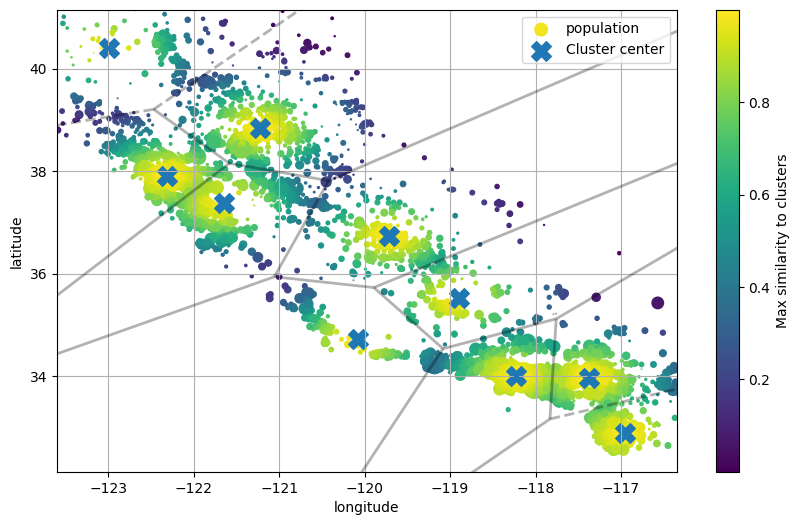

In [109]:
cluster_simil = ClusterSimilarity(n_clusters=10, gamma=1.0, random_state=42)
similarities = cluster_simil.fit_transform(housing[["latitude","longitude"]])


from scipy.spatial import Voronoi, voronoi_plot_2d

# Plot housing latitude and longitude with size of the dot scaling with population and color with max similarity to cluster center

ax = housing.plot(kind = "scatter", x = "longitude", y = "latitude",  s=housing["population"]/100, sharex = False, label = "population", c = np.max(similarities,axis=1), grid = True, figsize = (10,6))



# Plot the cluster centers

centers = cluster_simil.kmeans_.cluster_centers_

ax.scatter(centers[:,1],centers[:,0], marker="X", s = 200, label = "Cluster center")



# Set the colorbar and the label
sm = plt.cm.ScalarMappable(cmap='viridis')
sm.set_array(np.max(similarities, axis=1))
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label("Max similarity to clusters")


# Plot Voronoi diagram to highlight the cluster boundaries



centers_xy = centers[:, [1, 0]]

vor = Voronoi(centers_xy)
voronoi_plot_2d(vor, show_vertices=False, line_colors='black', line_width=2, ax = ax, line_alpha=0.3,)



ax.legend()


plt.show()

### Chain all transformers together

So far we have performed the following transformations on "housing":

1. Inputation (using median) to fill missing values
2. Create new features using ratios of preexisting features (e.g. bedrooms per rooms)
3. Cluster similarity (using KMeans and RBF kernel)
4. One-hot encoding (to turn non-numerical features into numbers)
5. Log-transformation for heavy tailed features
6. Standardise all features so that they have similar scales

We now design a pipeline to perform all of those transformations.


In [110]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import make_column_selector


def column_ratio(X):
    X = np.asanyarray(X)
    return X[:,[0]]/X[:,[1]]  #we use X[:,[0]] so that the outcome is of np.shape (#data ,1)


def ratio_name(function_transformer, features_name_in):
    return ["ratio"]



def ratio_pipeline():
    return make_pipeline(
        SimpleImputer(strategy="median"),
        FunctionTransformer(column_ratio, feature_names_out=ratio_name),
        StandardScaler())


log_pipeline = make_pipeline(SimpleImputer(strategy="median"),FunctionTransformer(np.log, feature_names_out="one-to-one"), StandardScaler())


num_pipeline = num_pipeline = make_pipeline(SimpleImputer(strategy="median"), StandardScaler())

cat_pipeline = make_pipeline(SimpleImputer(strategy="most_frequent"), OneHotEncoder(handle_unknown="ignore"))



preprocessing = ColumnTransformer([("bedrooms", ratio_pipeline(), ["total_bedrooms", "total_rooms"]), 
                                  ("rooms_per_house", ratio_pipeline(), ["total_rooms","households"]),
                                  ("people_per_house", ratio_pipeline(), ["population","households"]),
                                  ("log", log_pipeline, ["total_bedrooms", "total_rooms","population", "households", "median_income"]),
                                  ("geo", cluster_simil, ["latitude", "longitude"]),
                                  ("cat", cat_pipeline, make_column_selector(dtype_include=object))],
                                   remainder=num_pipeline)

In [111]:
housing_prepared = preprocessing.fit_transform(housing)

housing_prepared = pd.DataFrame(housing_prepared, columns=preprocessing.get_feature_names_out(), index = housing.index)

housing_prepared.info()


<class 'pandas.core.frame.DataFrame'>
Index: 16512 entries, 13096 to 19888
Data columns (total 24 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   bedrooms__ratio                  16512 non-null  float64
 1   rooms_per_house__ratio           16512 non-null  float64
 2   people_per_house__ratio          16512 non-null  float64
 3   log__total_bedrooms              16512 non-null  float64
 4   log__total_rooms                 16512 non-null  float64
 5   log__population                  16512 non-null  float64
 6   log__households                  16512 non-null  float64
 7   log__median_income               16512 non-null  float64
 8   geo__Cluster 0 similarity        16512 non-null  float64
 9   geo__Cluster 1 similarity        16512 non-null  float64
 10  geo__Cluster 2 similarity        16512 non-null  float64
 11  geo__Cluster 3 similarity        16512 non-null  float64
 12  geo__Cluster 4 simi

# Select and Train a Model


We are now ready to train a model. We consider two models for the moment

1. Linear regression
2. Decision tree

and we compute the root mean squared error (RMSE) for both.

In [112]:
# Linear Regression

from sklearn.linear_model import LinearRegression


lin_reg = make_pipeline(preprocessing, LinearRegression())


lin_reg.fit(housing, housing_labels)

housing_predictions_lin = lin_reg.predict(housing)


print(housing_predictions_lin[:5].round(2))

print(housing_labels.iloc[:5].values.round(2))  # we can see that some predictions are off


# Calculate the RMSE


from sklearn.metrics import root_mean_squared_error

lin_rmse = root_mean_squared_error(housing_labels, housing_predictions_lin)

print(lin_rmse)


# Decision tree

from sklearn.tree import DecisionTreeRegressor


tree_reg = make_pipeline(preprocessing, DecisionTreeRegressor(random_state=42))

tree_reg.fit(housing, housing_labels)

housing_predictions_tree = tree_reg.predict(housing)

tree_rmse = root_mean_squared_error(housing_labels, housing_predictions_tree)

print(tree_rmse)



[245970.16 372738.07 135706.8   91440.93 330873.54]
[458300. 483800. 101700.  96100. 361800.]
68972.88910758478
0.0


We can observe the following:

* **Linear Regression**: Likely **underfits** the training set, as the training RMSE is still relatively high.  
* **Decision Tree**: Likely **overfits** the training set, as the training RMSE is essentially zero.  

**Recall:**

* **Underfitting** occurs when a model has a **high training error** — it is too simple to capture the underlying patterns.  
* **Overfitting** occurs when a model has a **low training error** but performs poorly on unseen data — it has learned noise instead of general patterns.  

**Strategies to fix underfitting:**

* Add more informative features.  
* Use a more complex model.  

**Strategies to fix overfitting:**

* Use a simpler model.  
* Apply regularization to constrain the model.  

**Validation:**

To determine if a model is overfitting, we should evaluate it on a **validation set**. A common approach is **cross-validation**:

1. Split the training set into $k$ non-overlapping subsets called **folds**.  
2. Train the model on all combinations of $k-1$ folds and validate it on the remaining fold.  
3. Repeat this process for each fold, yielding $k$ validation scores.  
4. Compute the **average** and **standard deviation** of these scores to assess model performance.


In general, the score used in cross-validation is a **utility function** (higher is better), rather than a **loss function** (like RMSE) for which lower is better.  

A **stable model** typically has:

* A **high score** (performs well on average across folds)  
* A **small standard deviation** (performs consistently across folds)

In [113]:
from sklearn.model_selection import cross_val_score

tree_rmses = -cross_val_score(tree_reg, housing, housing_labels, cv = 10, scoring="neg_root_mean_squared_error") # - to turn utility function to loss function


pd.Series(tree_rmses).describe()

count       10.000000
mean     66573.734600
std       1103.402323
min      64607.896046
25%      66204.731788
50%      66388.272499
75%      66826.257468
max      68532.210664
dtype: float64

In [114]:
lin_rmses = -cross_val_score(lin_reg, housing, housing_labels, cv = 10, scoring="neg_root_mean_squared_error")


pd.Series(lin_rmses).describe()

count       10.000000
mean     70003.404818
std       4182.188328
min      65504.765753
25%      68172.065831
50%      68743.995249
75%      70344.943988
max      81037.863741
dtype: float64

We can see that, using cross-validation, the **Decision Tree** does **not perform much better** than **Linear Regression**, despite the very low training RMSE observed on the full training set. This confirms that the Decision Tree is likely **overfitting** the training data. To avoid overfitting, we try a random forest model. This is an ensemble model that averages over many decision tress to reduce the error and overfitting.

In [115]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = make_pipeline(preprocessing, RandomForestRegressor(random_state=42))

forest_rmses = -cross_val_score(forest_reg, housing, housing_labels, cv = 10, scoring="neg_root_mean_squared_error")


pd.Series(forest_rmses).describe()

count       10.000000
mean     47038.092799
std       1021.491757
min      45495.976649
25%      46510.418013
50%      47118.719249
75%      47480.519175
max      49140.832210
dtype: float64

The models perform roughly as follows:

* Linear regression: mean = 70 003  std = 4 182
* Decision tree:     mean = 66 574  std = 1 103
* Random forest:     mean = 47 038  std = 1 021

We can see that the random forest is the model that performs the best. We can also consider 2 other models for investigation:

1. ElasticNet (Linear regression plus Lasso and Ridge regularisation)
2. KNN (k-nearest neighbours)

In [116]:
from sklearn.linear_model import ElasticNet


elastic_net = make_pipeline(preprocessing, ElasticNet(random_state=42))

elastic_net_loss = - cross_val_score(elastic_net, housing, housing_labels, cv = 10, scoring="neg_root_mean_squared_error")


pd.Series(elastic_net_loss).describe()

count       10.000000
mean     81940.935938
std       1424.243528
min      79805.079641
25%      81077.959526
50%      81844.509285
75%      82992.200256
max      84139.540639
dtype: float64

In [117]:
from sklearn.neighbors import KNeighborsRegressor


knn_reg = make_pipeline(preprocessing, KNeighborsRegressor()) 
knn_rmses = - cross_val_score(knn_reg, housing, housing_labels, cv = 10, scoring="neg_root_mean_squared_error")


pd.Series(knn_rmses).describe()

count       10.000000
mean     60327.702812
std       1962.912268
min      56783.242306
25%      59424.261053
50%      61065.944783
75%      61489.439418
max      62629.575305
dtype: float64

### Fine-tuning

Some of the models we used require setting **hyperparameters**. For example, the maximum depth of a decision tree or the maximum number of features considered when splitting a node in a random forest. There are two common approaches to tune these hyperparameters:

1. **Grid Search**  
2. **Randomized Search**

With **Grid Search**, we test every possible combination of the hyperparameter values we provide.  

With **Randomized Search**, we test only a random subset of all possible combinations.

Grid Search is usually best when the search space is small, while Randomized Search is more efficient when the search space is large.

Both GridSearchCV and RandomizedSearchCV from sklearn require an untrained model; hence, we make a new pipeline. They also require the name of the nested estimators to be seperated by a double underscore (se code below)

In [156]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV



# Grid search
param_grid = [{"columntransformer__geo__n_clusters": [5,8,10], "randomforestregressor__max_features":[4,6,8]}, {"columntransformer__geo__n_clusters": [8,15], "randomforestregressor__max_features": [6,8,10]}]  #use __ to separate nested parameter names

forest_reg_pipeline = make_pipeline(preprocessing, RandomForestRegressor(random_state=42))

grid_search = GridSearchCV(forest_reg_pipeline, param_grid, cv = 3, scoring="neg_root_mean_squared_error") 

grid_search.fit(housing, housing_labels)

print(grid_search.best_params_)

{'columntransformer__geo__n_clusters': 15, 'randomforestregressor__max_features': 6}


In [159]:
# Randomized search

from scipy.stats import randint
param_distribs = {'columntransformer__geo__n_clusters': randint(low=3,high=50),"randomforestregressor__max_features": randint(low=2,high=20)}
rnd_search = RandomizedSearchCV(forest_reg_pipeline, param_distributions=param_distribs, n_iter=10, cv=3,scoring='neg_root_mean_squared_error', random_state=42)

rnd_search.fit(housing, housing_labels)
print(rnd_search.best_params_)

{'columntransformer__geo__n_clusters': 45, 'randomforestregressor__max_features': 9}


In [ ]:
final_model = rnd_search.best_estimator_   #this perform fit() with the rnd_search (defined before) using the best hyper-parameters 

feature_importances = final_model["randomforestregressor"].feature_importances_

sorted(zip(feature_importances.round(2), final_model["columntransformer"].get_feature_names_out()), reverse=True)  #feature_importances is an attr of tree-like models


[(np.float64(0.19), 'log__median_income'),
 (np.float64(0.07), 'cat__ocean_proximity_INLAND'),
 (np.float64(0.07), 'bedrooms__ratio'),
 (np.float64(0.05), 'rooms_per_house__ratio'),
 (np.float64(0.05), 'people_per_house__ratio'),
 (np.float64(0.04), 'geo__Cluster 30 similarity'),
 (np.float64(0.03), 'geo__Cluster 25 similarity'),
 (np.float64(0.02), 'geo__Cluster 9 similarity'),
 (np.float64(0.02), 'geo__Cluster 7 similarity'),
 (np.float64(0.02), 'geo__Cluster 37 similarity'),
 (np.float64(0.02), 'geo__Cluster 36 similarity'),
 (np.float64(0.02), 'geo__Cluster 34 similarity'),
 (np.float64(0.02), 'geo__Cluster 32 similarity'),
 (np.float64(0.02), 'geo__Cluster 18 similarity'),
 (np.float64(0.02), 'geo__Cluster 13 similarity'),
 (np.float64(0.02), 'geo__Cluster 1 similarity'),
 (np.float64(0.01), 'remainder__housing_median_age'),
 (np.float64(0.01), 'log__total_rooms'),
 (np.float64(0.01), 'log__total_bedrooms'),
 (np.float64(0.01), 'log__population'),
 (np.float64(0.01), 'log__househo

We can see that the most important features for splitting are:

1. Median income  
2. Whether the district is inland  
3. Bedrooms per room in that district  

The values in `feature_importances_` are weights that sum to **1**. The higher the weight, the more important the feature is for the model’s predictions.

Something that should also be performed (but we will not do here) is **bias analysis**. We should create validation test sets that are intentionally biased (for example, districts that are rural vs. urban, or rich vs. poor) and evaluate the model on these subsets.

If the model works well, it should not only perform well on average, but also perform consistently across these biased subsets. This relates to **model fairness**.

## Evaluate the Model on the Test Set

We are now ready to check the model on the test set.
Note that this should be the last thing we do, after this we are not allowed to check performance again on the test set.

In [165]:
X_test = strat_test_set.drop("median_house_value", axis = 1)

y_test = strat_test_set["median_house_value"].copy()

final_predictions = final_model.predict(X_test)

final_rmse = root_mean_squared_error(y_test, final_predictions)

print(final_rmse)

41445.533268606625


Sometimes the **root mean square error (RMSE)** is not very informative, because it depends on the scale of the target variable. To overcome this, we can use the **$R^2$ metric**, defined as:

$$
R^2 = 1 - \frac{\sum_{i=1}^{N} (y_i - \hat{y}_i)^2}{\sum_{i=1}^{N} (y_i - \bar{y})^2}
$$

where:  

- $y_i$ is the true target value of the $i$-th data point in the test set of $N$ points  
- $\hat{y}_i$ is the predicted value for $y_i$ from our model  
- $\bar{y}$ is the average of all $y_i$

The advantage of $R^2$ is that it is **unitless** and provides a normalized measure of performance:  

- $R^2 = 0$ → the model performs no better than predicting the mean of the labels  
- $R^2 < 0$ → the model performs worse than predicting the mean  
- $R^2 = 1$ → the model predicts all labels perfectly

In [166]:
from sklearn.metrics import r2_score


final_r2 = r2_score(y_test, final_predictions)

print(final_r2)

0.8716765957583981


## Launching the model and mantainance 

We now have a final model, we first need to save it, to do so we use the library joblib which is is optimized to be fast and robust on large data in particular. We save the model in a pickle file.

In [ ]:
import joblib

joblib.dump(final_model, "my_california_housing_model.pkl")

['my_california_housing_model.pkl']

After deployment, you should **monitor your model regularly** by checking its performance metrics (like RMSE or R²) and input data quality. Set up automated scripts that run on new data, trigger alerts if performance drops, and keep backups so you can retrain or roll back the model as needed. This helps detect data drift or other issues before they impact production.